# Reachinator

`Reachinator` is a deep deterministic policy gradeint (DDPG) agent trained to play [Unity ML-Agent Toolkit](https://github.com/Unity-Technologies/ml-agents)'s [Reacher](https://www.youtube.com/watch?v=2N9EoF6pQyE). We train 20 agents simultaneously to keep close to the goal location as long as possible (+0.1 per time step). The model solved the environment (scoring a 100-play moving average across all agents of 30 or above) in 104 episodes (roughly 15 minutes). The weights of trained network are saved as `actor_optimal.pth` and `critic_optimal.pth`.

## Imports

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import trange
from collections import deque

#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#RL
from network import Actor, Critic
from memory import VanillaMemory
from agent import Agent

## Environment

The environment consists of 33 values that describe a state and 4 values that describe an action. The state represents position, rotation, velocity, and angular velocities of the two arm Rigidbodies. The action is torque applicable to two joints. The episode ends after 1000 timesteps. These rewards sum up to a score at the end of each episode (1000 timesteps). The environment is considered solved when the average score of the last 100 episodes exceed 30.

In [2]:
env = UnityEnvironment(file_name="Reacher_Linux_NoVis/Reacher.x86_64")
# env = UnityEnvironment(file_name="Reacher_Linux_OneAgent/Reacher.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print(f'Number of agents: {num_agents}')

# size of each action
action_size = brain.vector_action_space_size
print(f'Size of each action: {action_size}')

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print(f'There are {states.shape[0]} agents. Each observes a state with length: {state_size}')
print(f'The state looks like for the first agent: {states[0]}')

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state looks like for the first agent: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Agent

We adopted the DDPG agent used to train the Bipedal-Walker in [Udacity DRLND repository](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal) with some changes to the hyperparameters as follows. 

We also noticed that training once every timestep early on helps the agent learn faster but as time goes on we do not need to train that often so we annealed the `update_interval` as time goes on to save training time. This solves the problem in the benchmark implementation where training too often all the time leads to instability.

We also collected the losses of actor and critic to help with finetuning the agent.

In [5]:
mem = VanillaMemory(int(1e5), seed = 0)
agent = Agent(state_size=33, action_size=4, replay_memory=mem, random_seed=0, 
              nb_agent = 20, bs = 128,
              gamma=0.99, tau=1e-3, lr_actor=1e-4, lr_critic=1e-4, wd_actor=0, wd_critic=0,
              clip_actor = None, clip_critic = None, update_interval = 1, update_times = 1)

def get_update_interval(episode, start_update_interval = 1, end_update_interval = 20, gamma = 1.03):
    res = int(start_update_interval * gamma ** (episode))
    return(min(res,end_update_interval))

In [6]:
scores = []
moving_scores = []
scores_avg = deque(maxlen=100)
n_episodes = 500
nb_agent = 20

for episode in trange(n_episodes):
    #get initial states
    env_info = env.reset(train_mode=True)[brain_name]            
    states = env_info.vector_observations
    agent.reset_noise()                                             
    score = np.zeros(nb_agent)
    agent.update_interval = get_update_interval(episode)

    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]                 # env step                    
        next_states = env_info.vector_observations               # get the next state        
        rewards = env_info.rewards                               # get the reward        
        dones = env_info.local_done                              # see if episode has finished        
        agent.step(states, actions, rewards, next_states, dones) # agent step
        score += rewards                                         # update the score
        states = next_states                                     # roll over the state to next time step        
        if np.any(dones):                                        # exit loop if episode finished        
            break     
            
    #book keeping
    scores.append(np.mean(score))
    scores_avg.append(np.mean(score))
    moving_scores.append(np.mean(scores_avg))

    #print scores intermittenly
    if episode % 10 ==0: print(f'Episode: {episode} Score: {np.mean(score)} Average Score: {np.mean(scores_avg)}')

    #break if done
    if (np.mean(scores_avg) >= 30) & (len(scores_avg) == 100):
        print(f'Environment solved in {episode} episodes! Average Score: {np.mean(scores_avg)}')
        break    


  0%|          | 1/500 [00:14<1:59:32, 14.37s/it]

Episode: 0 Score: 0.5914999867789448 Average Score: 0.5914999867789448


  2%|▏         | 11/500 [02:43<2:01:06, 14.86s/it]

Episode: 10 Score: 1.8749999580904841 Average Score: 1.354772696991197


  4%|▍         | 21/500 [05:14<1:59:39, 14.99s/it]

Episode: 20 Score: 11.072499752510339 Average Score: 2.968690409835073


  6%|▌         | 31/500 [07:07<1:47:48, 13.79s/it]

Episode: 30 Score: 30.5709993166849 Average Score: 9.123693344456656


  8%|▊         | 41/500 [08:38<1:36:42, 12.64s/it]

Episode: 40 Score: 37.16199916936457 Average Score: 15.485828922157427


 10%|█         | 51/500 [09:53<1:27:06, 11.64s/it]

Episode: 50 Score: 37.261999167129396 Average Score: 19.765617205262842


 12%|█▏        | 61/500 [11:02<1:19:28, 10.86s/it]

Episode: 60 Score: 37.6744991579093 Average Score: 22.646589657743693


 14%|█▍        | 71/500 [12:00<1:12:36, 10.15s/it]

Episode: 70 Score: 37.969999151304364 Average Score: 24.751407897467136


 16%|█▌        | 81/500 [12:54<1:06:48,  9.57s/it]

Episode: 80 Score: 37.75349915614352 Average Score: 26.30993768353199


 18%|█▊        | 91/500 [13:45<1:01:50,  9.07s/it]

Episode: 90 Score: 37.427499163430184 Average Score: 27.543323560182913


 20%|██        | 101/500 [14:33<57:30,  8.65s/it]

Episode: 100 Score: 37.933999152109024 Average Score: 28.821184355796312


 21%|██        | 104/500 [14:47<56:19,  8.53s/it]

Environment solved in 104 episodes! Average Score: 30.27462932330929


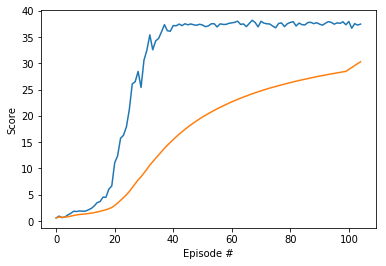

In [9]:
plt.plot(scores)
plt.plot(moving_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()    

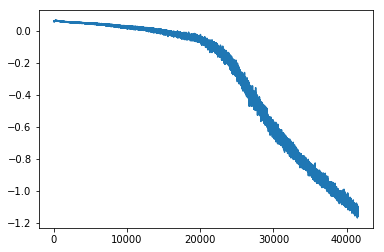

In [13]:
plt.plot(agent.actor_losses)

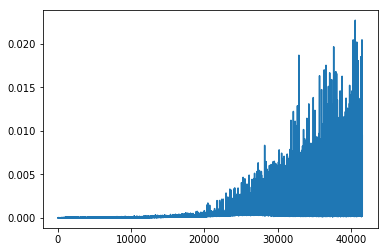

In [14]:
plt.plot(agent.critic_losses)

## Save Model Weights

In [12]:
#save models
torch.save(agent.actor_local.state_dict(),'actor_optimal.pth')
torch.save(agent.critic_local.state_dict(),'critic_optimal.pth')

## Future Works

It is to be noticed that DDPG is a very close algorithm to DQN and I suspect similar tricks should work here too such as:

1. **Noisy networks for better exploration** since we removed the epsilon-greedy element altogehter in DDPG some kind of exploration should help improve performance.
2. **Prioritized experience** should help the critic learns better and in term improve the performance of the actor. I actually tried it here but it was too slow.
3. **Advantage instead of action values** should work similarly to how dueling networks improve DQN.